# Fitting to ascospore data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd

# For plotting
from Functions_plotting import plot_one_intervention, c1, c2, c3, c4, c5
from Functions_base import G, Temerge, T61,T87

# For ODEs
from Functions_base import ic_twofield, t_growing, beta_base, Temerge, gamma, g_1D, sigma, mu, v

# Fitting to the data

In [2]:
# Data from "Is the onset...."
# But I'll shift seedling emergence date back to our 20th September. The first date measured is 10th October which is -6 days before sowing, which in 2012 was 16th October
# So I'll shift the first data point (10th October) to be day -12; subtract 32
data_date = np.array([20,53,78,111,165])-26
data_asc = np.array([15082.8025477707, 4076.43312101911, 2929.93630573248, 2063.69426751592, 0])

In [3]:
# Curve to fit
def ascospore_curve(t,delta,A):
    return A*np.exp(-delta*t)

def fit_data_to_curve(para):
    delta,A = para
    simulations = ascospore_curve(data_date, delta,A)
    return np.linalg.norm(simulations-data_asc)

x = minimize(fit_data_to_curve, [0.01,1000],method="Nelder-Mead")
print(x["x"])
delta,A = x["x"]

[3.23963347e-02 1.22620795e+04]


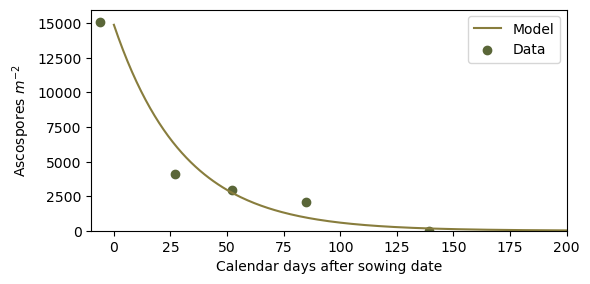

In [4]:
fig,ax = plt.subplots(1,figsize = (6,3))
ax.plot(ascospore_curve(range(-6,365),delta,A),color=c3,label = "Model")
ax.scatter(data_date,data_asc,color=c4,label = "Data")
ax.set_xlim([-10,200])
ax.set_xlabel("Calendar days after sowing date")
ax.set_ylim([0,16000])
ax.set_ylabel(r"Ascospores $m^{-2}$")
ax.legend(loc = "upper right")
plt.tight_layout()

fig.savefig('Figures/Manuscript_final/fig_ascosporedata.pdf', dpi=400)

# Apply this fitting output to the IPM model

In [5]:
def get_ascospores(late_sow):
    # Read in Hobbelen time data, converts calendar days to degree days
    T = pd.read_excel("Hobbelen_data/T - winter wheat_mine.xlsx", header=None,usecols=[0,1,2,3])
    
    # First leaf takes 150 degree days to develop (ref: Wheat Growth Guide 2008)
    def delay_first_leaf(n_days_late):
        i = 0
        while i < T.shape[0] and T.iloc[i,3] < 150:
            i += 1
        return i

    # Find out when you start being exposed to ascospores if you plant "n" days late
    first_leaf = delay_first_leaf(late_sow) + late_sow
    asc_delay = ascospore_curve(first_leaf,delta,A)    
    
    return asc_delay

def get_growth_delay_DD(late_sow):
    T = pd.read_excel("Hobbelen_data/T - winter wheat_mine.xlsx", header=None,usecols=[0,1,2,3])
    
    # Find out how many degree-days of growth need to be made up later
    growth_delay_dd = np.sum(T[2][:late_sow])    
    return growth_delay_dd

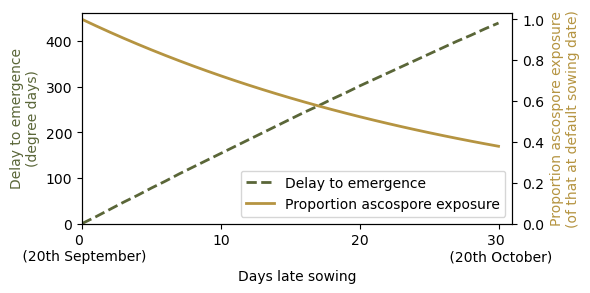

In [6]:
# Run for 56 days as the Wheat Growth Guide 2008 suggests the latest reasonable late sowing is mid-November, which is 56 days late (note we need 57 in length because of 0 days late being included)
N = 31
days_delay = np.zeros(N)
prop_asc = np.zeros(N)
dd_delay = np.zeros(N)
for i in range(N):

    # Compute calendar day delay, proportion of ascospore exposure, and degree-day delay
    days_delay[i] = i
    prop_asc[i] = get_ascospores(i)/get_ascospores(0)
    dd_delay[i] = int(get_growth_delay_DD(i))

# Plot SI figure, prop_asc and dd_delay over the various delay options
fig,ax = plt.subplots(1,figsize=(6,3))
l1, = ax.plot(dd_delay,c=c4,label="Delay to emergence",linewidth=2,linestyle='--')
ax.set_ylabel("Delay to emergence\n(degree days)")
labels = [str(i) for i in range(0,N,10)]
labels[0] = "0 \n (20th September)"
labels[3] = "30 \n (20th October)"
ax.set_xticks(ticks = range(0,N,10),labels = labels)
ax.set_xlabel("Days late sowing")
ax.set_xlim([0,N])
ax.set_ylim(bottom = 0)

ax2 = ax.twinx()
l2, = ax2.plot(prop_asc,c=c2,label = "Proportion ascospore exposure",linewidth=2)
ax2.set_ylabel("Proportion ascospore exposure\n(of that at default sowing date)")
ax2.set_ylim(bottom = 0)

ax.legend([l1,l2], [l1.get_label(), l2.get_label()], loc = "lower right")
ax.yaxis.label.set_color(l1.get_color())
ax2.yaxis.label.set_color(l2.get_color())

plt.tight_layout()
fig.savefig('Figures/Manuscript_final/fig_sowing_delay_ascospores.pdf', dpi=400)

In [7]:
# Save outputs
np.save("dd_delay.npy",dd_delay)
np.save("prop_asc.npy",prop_asc)

In [8]:
# Print values we're interested in - obtained later
print(prop_asc[0])
print(prop_asc[3])
print(prop_asc[7])
print(prop_asc[14])

1.0
0.9073844905095134
0.7971006333596382
0.6353694197023364


## Run key scenarios for paper

In [9]:
# Disease system
def dPop(ic,t,epi_severity,growth_delay):
    
    beta = beta_base*epi_severity
    
    S_M,E_M,I_M,R_M,D_M,P_M = ic[:6]
    S_N,E_N,I_N,R_N,D_N,P_N = ic[6:]
    
    A_M = S_M + E_M + I_M + R_M + D_M
    A_N = S_N + E_N + I_N + R_N + D_N
    
    # Residue management and late sowing fields
    if t > Temerge + growth_delay :
        FOL = gamma*E_M
            
        # Set transmission rate
        FOI = beta*(I_M + P_M)

        dS_M = g_1D(A_M,t) - sigma(t)*S_M - (S_M/A_M)*FOI
        dE_M = (S_M/A_M)*FOI - sigma(t)*E_M - FOL
        dI_M = FOL - mu*I_M
        dR_M = sigma(t)*(S_M+E_M)
        dD_M = mu*I_M
        dP_M = -v*P_M
        
    else:
        dS_M = 0
        dE_M = 0
        dI_M = 0
        dR_M = 0
        dD_M = 0
        dP_M = 0

    # Uncontrolled fields
    if t > Temerge:
        
        # Set uncontrolled FOI
        FOI = beta*(I_N + P_N)
        
        dS_N = g_1D(A_N,t) - sigma(t)*S_N - (S_N/A_N)*FOI
        dE_N = (S_N/A_N)*FOI - sigma(t)*E_N - gamma*E_N
        dI_N = gamma*E_N - mu*I_N
        dR_N = sigma(t)*(S_N+E_N)
        dD_N = mu*I_N
        dP_N = -v*P_N
        
    else:
        dS_N = 0
        dE_N = 0
        dI_N = 0
        dR_N = 0
        dD_N = 0
        dP_N = 0

    return [dS_M,dE_M,dI_M,dR_M,dD_M,dP_M, dS_N,dE_N,dI_N,dR_N,dD_N,dP_N]

In [10]:
# Find the "best yield" scenario
from Functions_analysis import Y
best_Y = -np.inf
best_i = -np.inf

for i in range(N):
    growth_delay = dd_delay[i]
    prop_ascospores = prop_asc[i]
    ic = 1*ic_twofield
    ic[5] = prop_ascospores*ic[5]
    this_pop = odeint(func = dPop, y0 = ic, t = t_growing, args = (1,growth_delay))
    this_Y = Y(this_pop[:,:6])
    print(i,this_Y)
    
    if this_Y > best_Y:
        best_Y = 1*this_Y
        best_i = 1*i
        
print("Best i is " + str(best_i))

# Now best has been found, run this scenario
sow_delay = best_i
growth_delay = dd_delay[sow_delay]
prop_ascospores = prop_asc[sow_delay]
ic = 1*ic_twofield
ic[5] = prop_ascospores*ic[5]

popbest = odeint(func = dPop, y0 = ic, t = t_growing, args = (1,growth_delay))

0 0.9003283189830485
1 0.908684795864862
2 0.9166954421380754
3 0.9239653936410495
4 0.9302401979625079
5 0.9361180379793298
6 0.941103614714047
7 0.9456634547816977
8 0.949428771931234
9 0.9526210660852037
10 0.9552514639978561
11 0.9573280304392632
12 0.9588551140524822
13 0.9598328437301781
14 0.9602564724875514
15 0.9601158913830532
16 0.9593949713130382
17 0.9582133382666655
18 0.9562959350628019
19 0.9539326115362409
20 0.9506790092370785
21 0.9469749269464764
22 0.9425455490362311
23 0.9373291350597944
24 0.9312541185632411
25 0.924237965498494
26 0.9161860873383718
27 0.9069905221831408
28 0.8973319507607103
29 0.8855682025745697
30 0.873268201313654
Best i is 14


In [11]:
# Max delay which results in an improvement
sow_delay = 14
growth_delay = dd_delay[sow_delay]
prop_ascospores = prop_asc[sow_delay]
ic = 1*ic_twofield
ic[5] = prop_ascospores*ic[5]
pop3 = odeint(func = dPop, y0 = ic, t = t_growing, args = (1,growth_delay))

# No control is minimum delay
pop1 = pop3[:,6:]

# Another option: 7 days
sow_delay = 7
growth_delay = dd_delay[sow_delay]
prop_ascospores = prop_asc[sow_delay]
ic = 1*ic_twofield
ic[5] = prop_ascospores*ic[5]
pop2 = odeint(func = dPop, y0 = ic, t = t_growing, args = (1,growth_delay))

Yields
[0.9003283668966523, 0.9456634547816977, 0.9602564724875514]
Peak percent infection
[0.1397656985939565, 0.07869540765054725, 0.04019216509824142]


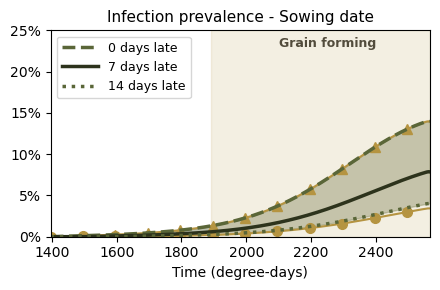

In [12]:
# Run imported plotting function
fig,ax = plot_one_intervention([pop1[:,:6],pop2[:,:6],pop3[:,:6]],["0 days late", "7 days late", "14 days late"],"Sowing date")
plt.tight_layout()
# Save figure
fig.savefig('Figures/Manuscript_final/fig_1control_latesowing.pdf', dpi=400)